<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_ImageAlignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: Image Alignment v1
Focused experiment into an alternative architecture for ImageAlignment.

This isn't actually the first such experiment. For earlier experiments see:
* `Experiment_SLAM_??.ipynb`  -- maybe v6?
* This notebook is also forked from the neuron-death/gradient-collapse notebook in the `training-instrumentation-toolkit`.

In this model, we start with an extreme alternative to downscaled-ConvNets -- a non-downscaled Conv + transformer.


In [3]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout af7505a
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import train_explainer as texpl
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

## Dataset Pipeline


In [4]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Corners of crop image (raw):
    [ 0.04074597 -0.33624923]                -         [ 0.45840526 -0.12344116]
    [-0.1720621   0.08141005]                -         [0.24559724 0.29421812]
Corners of crop image (pixels):
    [17.303871   5.2400246]                -         [30.668968 12.049883]
    [10.494013 18.605122]                -         [23.859112 25.41498 ]


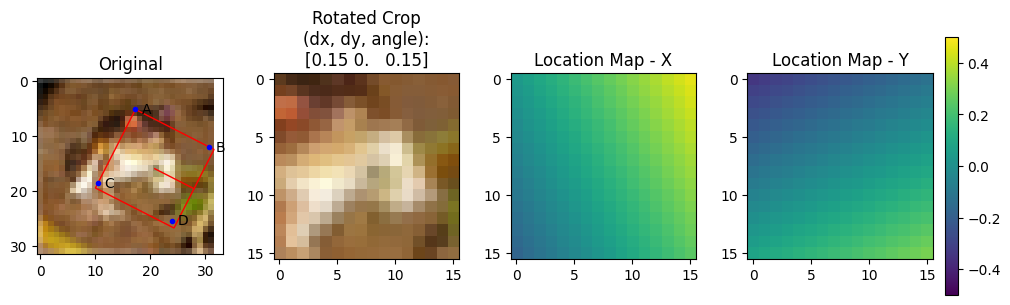

In [90]:
# image manipulation function
def rotated_crop(image, dx, dy, da, return_h_matrix=False):
    """
    Takes a 50% crop of the source image after applying a positional and angular
    offset relative to the image's centre.
    For example, (dx,dy,da) = (-0.25,0,0.5) will take a crop centred one quarter
    of the image width to the left from the source image centre and rotated
    45 degrees (50% of 180 in whichever direction the positive direction happens
    to take).
    Args:
      image: source image
      dx: float in range -0.5 .. +0.5 (fraction of width)
      dy: float in range -0.5 .. +0.5 (fraction of height)
      da: float in range -1.0 .. +1.0 (fraction of radians)
      return_location_map: bool. Whether to additionally return the homography matrix
    Returns:
      cropped_image
      OR
      cropped_image, homography_matrix (3x3)
    """
    # Image dimensions
    img_height, img_width = image.shape[0], image.shape[1]
    img_centre_x = img_width // 2
    img_centre_y = img_height // 2
    crop_size = img_height // 2  # 50% of original size (16x16 for CIFAR-10)
    crop_centre_x = crop_size // 2
    crop_centre_y = crop_size // 2

    # Step 1: Rotate crop window about its top-left corner
    # - assuming crop-mid is at (x,y)=(8,8)
    # - net result is that the crop-mid will move to crop_mid' = tf.linalg.matvec(R, crop_mid)
    R = tf.stack([
        [tf.cos(da * np.pi), -tf.sin(da * np.pi), 0],
        [tf.sin(da * np.pi), tf.cos(da * np.pi), 0],
        [0.0, 0.0, 1.0]
    ])
    R_neg = tf.stack([
        [tf.cos(-da * np.pi), -tf.sin(-da * np.pi), 0],
        [tf.sin(-da * np.pi), tf.cos(-da * np.pi), 0],
        [0.0, 0.0, 1.0]
    ])

    # Step 2a: Calculate crop-mid after rotation
    crop_mid = [crop_centre_x, crop_centre_y, 1.]
    crop_mid = tf.linalg.matvec(R, crop_mid)

    # Step 2b: Translate rotated location of crop-mid back to it's original position
    Tv = [crop_centre_x - crop_mid[0], crop_centre_y - crop_mid[1], 1.]

    # Step 2c: translate crop-mid to target location on source image
    tx = img_centre_x + dx * img_width - crop_centre_x
    ty = img_centre_y + dy * img_height - crop_centre_y
    Tv = [Tv[0] + tx, Tv[1] + ty, 1.]

    # Step 2d: reverse rotation impact before applying
    # - we'll apply the translation first, so it's ultimate effect is then rotated,
    #   so we counteract that effect by pre-rotating in the opposite direction
    Tv = tf.linalg.matvec(R_neg, Tv)
    T = tf.stack([
        [1.0, 0.0, Tv[0]],
        [0.0, 1.0, Tv[1]],
        [0.0, 0.0, 1.0]
    ])

    # combine transformations: R * T
    # - technically this is applying T first, and then R
    # - has effect of rotating crop window by R, and then translating by R(T)
    h_matrix = tf.linalg.matmul(R, T)

    # Flatten to 8 parameters (last is 1)
    transform = tf.reshape(h_matrix, [-1])[:-1]

    # Apply projective transform
    rotated_crop = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),  # Add batch dimension
        transforms=tf.expand_dims(transform, 0),  # Add batch dimension
        output_shape=[crop_size, crop_size],
        interpolation='BILINEAR',
        fill_value=0.0,
        fill_mode='CONSTANT'
    )[0]  # Remove batch dimension

    if return_h_matrix:
      return rotated_crop, h_matrix
    else:
      return rotated_crop

def compute_location_map(h_matrix, img_shape, crop_shape):
  """
  For each pixel (y, x) in the cropped image of shape (crop_height, crop_width, channels),
  computes where that pixel came from in the original image in normalized
  coordinates, i.e. (-0.5..+0.5, -0.5..+0.5).
  Args:
    h_matrix: 3x3 homography matrix
  Returns:
    location_map, shape (crop_height, crop_width, 2) of float, containing per-pixel locations
      from original image in range -0.5 .. +0.5 relative to original image centre.
  """
  img_width, img_height = img_shape[1], img_shape[0]
  crop_width, crop_height = crop_shape[1], crop_shape[0]

  # Build a meshgrid of output coords: shape (crop_size, crop_size)
  # indexing='ij' => Y first, then X
  y_coords = tf.range(crop_width, dtype=tf.float32)
  x_coords = tf.range(crop_height, dtype=tf.float32)
  Y, X = tf.meshgrid(y_coords, x_coords, indexing='ij')  # (crop_height, crop_width)

  # Stack and flatten => shape (crop_size*crop_size, 3)
  # - note: the transform requires coordinates in form (y, x, 1).
  ones = tf.ones_like(X)
  out_coords = tf.stack([Y, X, ones], axis=-1)
  out_coords_flat = tf.reshape(out_coords, [-1, 3])

  # Multiply: output -> input
  in_coords_flat = tf.linalg.matmul(out_coords_flat, h_matrix, transpose_b=True)

  # For safety in case of perspective transforms, divide by W
  in_coords_flat /= in_coords_flat[:, 2:3]

  # The returned in_coords_flat are [y, x, 1]. Slicing:
  in_y = in_coords_flat[:, 0]
  in_x = in_coords_flat[:, 1]

  # Normalize each axis to range [-0.5..+0.5]
  # center = W/2 or H/2, so x_norm = (X - W/2)/W
  x_norm = in_x / tf.cast(img_width, tf.float32)  - 0.5
  y_norm = in_y / tf.cast(img_height, tf.float32) - 0.5

  # Reshape back to (crop_height, crop_width, 2)
  pixel_map = tf.stack([x_norm, y_norm], axis=-1)
  pixel_map = tf.reshape(pixel_map, [crop_height, crop_width, 2])
  return pixel_map

def compute_location_map_xy(h_matrix, img_shape, crop_shape):
  """
  For each pixel (y, x) in the cropped image of shape (crop_height, crop_width, channels),
  computes where that pixel came from in the original image in normalized
  coordinates, i.e. (-0.5..+0.5, -0.5..+0.5).
  Args:
    h_matrix: 3x3 homography matrix
  Returns:
    location_map, shape (crop_height, crop_width, 2) of float, containing per-pixel locations
      from original image in range -0.5 .. +0.5 relative to original image centre.
  """
  img_width, img_height = img_shape[1], img_shape[0]
  crop_width, crop_height = crop_shape[1], crop_shape[0]

  # Build a meshgrid of output coords: shape (crop_size, crop_size)
  # indexing='ij' => Y first, then X
  y_coords = tf.range(crop_width, dtype=tf.float32)
  x_coords = tf.range(crop_height, dtype=tf.float32)
  Y, X = tf.meshgrid(y_coords, x_coords, indexing='ij')  # (crop_height, crop_width)

  # Stack and flatten => shape (crop_size*crop_size, 3)
  # - note: the transform requires coordinates in form (x, y, 1).
  ones = tf.ones_like(X)
  out_coords = tf.stack([X, Y, ones], axis=-1)
  out_coords_flat = tf.reshape(out_coords, [-1, 3])

  # Apply homography transform
  in_coords_flat = tf.linalg.matmul(out_coords_flat, h_matrix, transpose_b=True)
  in_coords_flat /= in_coords_flat[:, 2:3]  # safety: works for perspective changes too

  # The returned in_coords_flat are [x, y, 1]. Slicing:
  in_x = in_coords_flat[:, 0]
  in_y = in_coords_flat[:, 1]

  # Normalize each axis to range [-0.5..+0.5]
  # center = W/2 or H/2, so x_norm = (X - W/2)/W
  x_norm = in_x / tf.cast(img_width, tf.float32)  - 0.5
  y_norm = in_y / tf.cast(img_height, tf.float32) - 0.5

  # Reshape back to (crop_height, crop_width, 2)
  pixel_map = tf.stack([x_norm, y_norm], axis=-1)
  pixel_map = tf.reshape(pixel_map, [crop_height, crop_width, 2])
  return pixel_map

def draw_crop_template(image, transform):
  dx, dy, da = transform
  centre_x = image.shape[1] * (0.5 + dx)
  centre_y = image.shape[0] * (0.5 + dy)
  width = image.shape[1] // 2
  height = image.shape[0] // 2
  radians = da * np.pi

  # draw a rectangle showing the outline of where the crop was taken from
  ax = plt.gca()
  rect = patches.Rectangle((centre_x - width/2, centre_y - height/2), width, height, linewidth=1, edgecolor='r', facecolor='none')
  t = transforms.Affine2D().rotate_deg_around(centre_x, centre_y, radians * 180 / np.pi)
  rect.set_transform(t + ax.transData)
  ax.add_patch(rect)

  # draw a rotated 0-degrees line to indicate the rotation.
  line_end_x = centre_x + width / 2
  line_end_y = centre_y
  rotated_endpoint = t.transform([(line_end_x, line_end_y)])[0]
  ax.plot([centre_x, rotated_endpoint[0]], [centre_y, rotated_endpoint[1]], color='r', linewidth=1)

def decode_outputs(outputs):
  if isinstance(outputs, tuple):
    transform, location_map = outputs
  elif outputs.shape[-1] == 3:
    transform = outputs
    location_map = None
  else:
    transform = None
    location_map = outputs

  return transform, location_map

def show_data_sample(inputs, outputs):
  """
  Copes with usage any of:
  - show_data_sample((image, cropped), transform)
  - show_data_sample((image, cropped), location_map)
  - show_data_sample((image, cropped), (transform, location_map))
  """
  (image, cropped) = inputs
  transform, location_map = decode_outputs(outputs)

  plt.figure(figsize=(10, 3), layout='constrained')
  cols = 4 if location_map is not None else 2

  plt.subplot(1, cols, 1)
  plt.title("Original")
  plt.imshow(image)
  if transform is not None:
    draw_crop_template(image, transform)
  if location_map is not None:
    img_size_factor = np.array([image.shape[1], image.shape[0]])
    img_centre = np.array([image.shape[1] // 2, image.shape[0] // 2])
    a = location_map[0, 0, :] * img_size_factor + img_centre
    b = location_map[0, -1, :] * img_size_factor + img_centre
    c = location_map[-1, 0, :] * img_size_factor + img_centre
    d = location_map[-1, -1, :] * img_size_factor + img_centre
    points = np.array([a, b, c, d])
    plt.plot(points[:,0], points[:,1], 'b.')
    plt.text(a[0]+2, a[1], "A", horizontalalignment='center', verticalalignment='center')
    plt.text(b[0]+2, b[1], "B", horizontalalignment='center', verticalalignment='center')
    plt.text(c[0]+2, c[1], "C", horizontalalignment='center', verticalalignment='center')
    plt.text(d[0]+2, d[1], "D", horizontalalignment='center', verticalalignment='center')

    print(f"Corners of crop image (raw):")
    print(f"    {location_map[0, 0, :]}                -         {location_map[0, -1, :]}")
    print(f"    {location_map[-1, 0, :]}                -         {location_map[-1, -1, :]}")

    print(f"Corners of crop image (pixels):")
    print(f"    {a}                -         {b}")
    print(f"    {c}                -         {d}")

    # all points:
    #xs = location_map[..., 0] * img_size_factor[0] + img_centre[0]
    #ys = location_map[..., 1] * img_size_factor[1] + img_centre[1]
    #plt.plot(xs, ys, 'b.')

  plt.subplot(1, cols, 2)
  plt.title(f"Rotated Crop\n(dx, dy, angle):\n{transform}")
  plt.imshow(cropped)

  if location_map is not None:
    plt.subplot(1, cols, 3)
    plt.title(f"Location Map - X")
    plt.imshow(location_map[:,:,0], vmin=-0.5, vmax=+0.5)

    plt.subplot(1, cols, 4)
    plt.title(f"Location Map - Y")
    plt.imshow(location_map[:,:,1], vmin=-0.5, vmax=+0.5)
    plt.colorbar()

  plt.show()

image = x_train[0]
transform = tf.constant(([0.15, 0.0, 0.15]))
cropped, h_matrix = rotated_crop(image, dx=transform[0], dy=transform[1], da=transform[2], return_h_matrix=True)
location_map = compute_location_map_xy(h_matrix, image.shape, cropped.shape)
show_data_sample((image, cropped), (transform, location_map))

Original shape: (32, 32, 32, 3)
Rotated Crop shape: (32, 16, 16, 3)
Transformation shape: (32, 3)
Location Map shape: (32, 16, 16, 2)


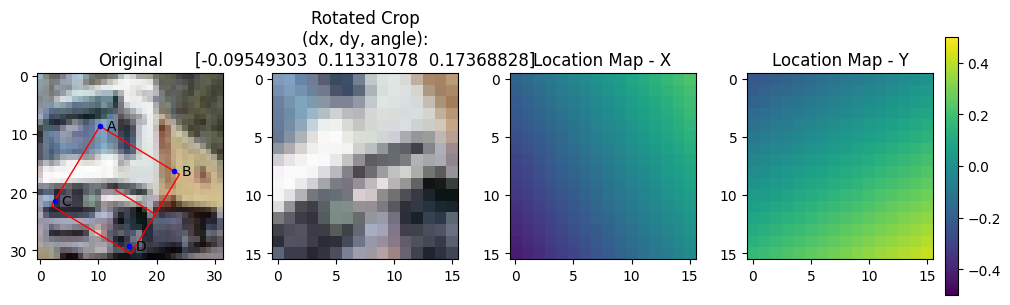

Time for 100 batches: 0.88 seconds
Total batches: 1563


In [75]:
# pre-processing pipeline
def _preprocess_image_configurable(image, return_transform: bool, return_location_map: bool):
    # Generate random translation and rotation
    # - dx/dy in range -0.5..+0.5 (fraction of width/height)
    # - da    in range -1.0..+1.0 (radians)
    # - small stddev
    dx = tf.clip_by_value(tf.random.normal([], mean=0, stddev=0.5/4), -0.5, 0.5)
    dy = tf.clip_by_value(tf.random.normal([], mean=0, stddev=0.5/4), -0.5, 0.5)
    da = tf.clip_by_value(tf.random.normal([], mean=0, stddev=1.0/4), -1.0, 1.0)

    # Take rotated crop
    cropped, h_matrix = rotated_crop(image, dx, dy, da, return_h_matrix=True)
    location_map = compute_location_map_xy(h_matrix, image.shape, cropped.shape)
    transform = tf.stack([dx, dy, da])

    # construct as input/output tuples
    if return_transform and return_location_map:
      return (image, cropped), (transform, location_map)
    elif return_transform:
      return (image, cropped), transform
    elif return_location_map:
      return (image, cropped), location_map
    else:
      raise ValueError(f"invalid output format: {return_transform=}, {return_location_map=}")

def preprocess_image_for_transform(image):
  return _preprocess_image_configurable(image, return_transform=True, return_location_map=False)

def preprocess_image_for_location_map(image):
  return _preprocess_image_configurable(image, return_transform=False, return_location_map=True)

def preprocess_image_for_both(image):
  return _preprocess_image_configurable(image, return_transform=True, return_location_map=True)

def prepared_dataset(output_format='transform'):
  if output_format == 'transform':
    preprocess_image = preprocess_image_for_transform
  elif output_format == 'location_map':
    preprocess_image = preprocess_image_for_location_map
  elif output_format == 'transform, location_map':
    preprocess_image = preprocess_image_for_both
  else:
    raise ValueError(f"invalid output format: {output_format}")

  train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
  train_dataset = train_dataset.map(
      preprocess_image,
      num_parallel_calls=tf.data.AUTOTUNE
  )
  return train_dataset

def take_first_sample(inputs, outputs):
  """Grabs the first sample from a batch"""
  (original, cropped) = inputs
  (transform, location_map) = decode_outputs(outputs)

  if transform is not None and location_map is not None:
    return (original[1], cropped[1]), (transform[1], location_map[1])
  elif transform is not None:
    return (original[1], cropped[1]), transform[1]
  elif location_map is not None:
    return (original[1], cropped[1]), location_map[1]

# Create the dataset pipeline
train_dataset = prepared_dataset('transform, location_map').batch(32).prefetch(tf.data.AUTOTUNE)

# Test and visualize
for inputs, outputs in train_dataset.take(1):
    (original, cropped) = inputs
    (transform, location_map) = decode_outputs(outputs)

    print("Original shape:", original.shape)         # [batch, 32, 32, 3]
    print("Rotated Crop shape:", cropped.shape)      # [batch, 16, 16, 3]
    if transform is not None:
      print("Transformation shape:", transform.shape)  # [batch, 3]
    if location_map is not None:
      print("Location Map shape:", location_map.shape)  # [batch, 16, 16, 2]

    input, output = take_first_sample(inputs, outputs)
    show_data_sample(input, output)

# Optional: Time the pipeline
import time
start = time.time()
for _ in train_dataset.take(100):  # Process 100 batches
    pass
print(f"Time for 100 batches: {time.time() - start:.2f} seconds")
print(f"Total batches: {len(train_dataset)}")

In [83]:
def show_model_output(dataset, model):
  for inputs, true_outputs in dataset.take(1):
    pred_outputs = model(inputs)

    (transform, location_map) = decode_outputs(true_outputs)
    (transform_pred, location_map_pred) = decode_outputs(pred_outputs)

    input, true_output = take_first_sample(inputs, (transform, location_map))
    _, pred_output = take_first_sample(inputs, (transform_pred, location_map_pred))
    show_data_sample(input, true_output)
    show_data_sample(input, pred_output)

## Model


In [10]:
# CoordConv layer
# Based on R. Liu et al., “An Intriguing Failing of CNNs and the CoordConv Solution,” NeurIPS 2018
# https://arxiv.org/abs/1807.03247
class CoordConv(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid:
        # - x_coords: shape (width,) from -0.5 to 0.5
        # - y_coords: shape (height,) from -0.5 to 0.5
        x_coords = tf.linspace(-0.5, 0.5, width)
        y_coords = tf.linspace(-0.5, 0.5, height)

        # Use meshgrid to get 2D coordinate maps
        # - xx, yy shape => (height, width)
        xx, yy = tf.meshgrid(x_coords, y_coords)

        # Reshape for appending as channels
        xx = tf.expand_dims(xx, axis=-1)  # (height, width, 1)
        yy = tf.expand_dims(yy, axis=-1)  # (height, width, 1)

        # Tile across batch dimension
        xx_tiled = tf.tile(tf.expand_dims(xx, 0), [batch_size, 1, 1, 1])
        yy_tiled = tf.tile(tf.expand_dims(yy, 0), [batch_size, 1, 1, 1])

        # Concatenate to inputs along the channel dimension
        # outputs.shape => [batch_size, height, width, channels+2]
        output = tf.concat([inputs, xx_tiled, yy_tiled], axis=-1)
        return output

input = tf.keras.Input(shape=(32, 32, 3))
cc = CoordConv()(input)
cc.shape

(None, 32, 32, 5)

In [98]:
def location_map_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    x = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mhe")(
        query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x128 -> 16x16x128 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='head_conv')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
location_map_model().summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coord_conv_39 (CoordConv) │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coord_conv_40 (CoordConv) │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ coord_conv_39[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ coord_conv_40[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2 (Conv2D)         │ (None, 32, 32, 16)     │          1,168 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2 (Conv2D)         │ (None, 16, 16, 16)     │          1,168 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ x1_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ x2_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ x1_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv4 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ x2_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv5 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ x1_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv5 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ x2_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape1 (Reshape)     │ (None, 1024, 128)      │              0 │ x1_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape1 (Reshape)     │ (None, 256, 128)       │              0 │ x2_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mhe1                 │ (None, 256, 128)       │         98,944 │ x1_reshape1[0][0],     │
│ (MultiHeadAttention)      │                        │                │ x2_reshape1[0][0],     │
│                           │                        │                │ x1_reshape1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_reshape1 (Reshape)   │ (None, 16, 16, 128)    │              0 │ head_mhe1[0][0]        │
├──────────────────────

 Total params: 296,258 (1.13 MB)

 Trainable params: 296,258 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
model = location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 0.0367
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0367
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0363
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.0363
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0368
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0363
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0364
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0367
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0370
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0364
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0370
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0362
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0359
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0362
Epoch 15/50
188/188 ━━━━━━━━━

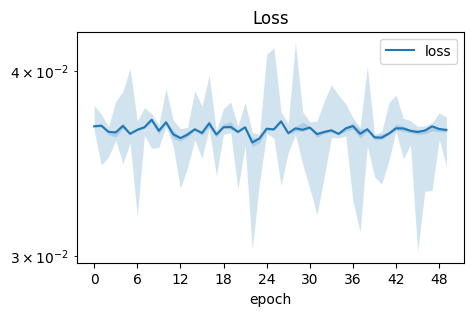

In [112]:
tinstr.plot_train_history(history)

Corners of crop image (raw):
    [-0.268889   -0.44060558]                -         [ 0.19924057 -0.41649613]
    [-0.29299843  0.02752399]                -         [0.17513114 0.05163348]
Corners of crop image (pixels):
    [7.3955517 1.9006214]                -         [22.375698  2.672124]
    [ 6.62405  16.880768]                -         [21.604197 17.652271]


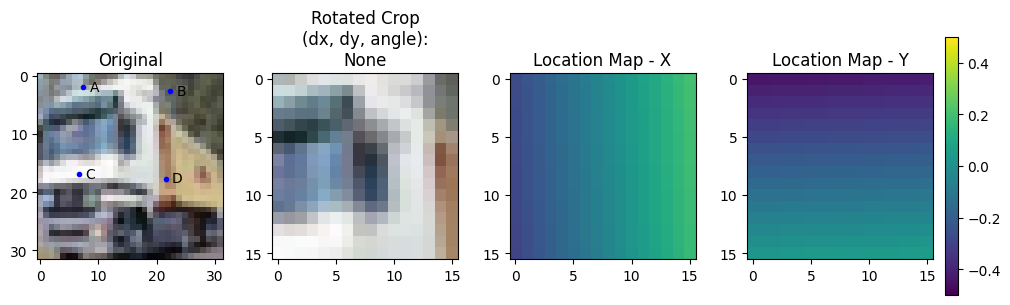

Corners of crop image (raw):
    [-0.01858782 -0.01025677]                -         [-0.01858782 -0.01025677]
    [-0.01858782 -0.01025677]                -         [-0.01858782 -0.01025677]
Corners of crop image (pixels):
    [15.4051895 15.671783 ]                -         [15.4051895 15.671783 ]
    [15.4051895 15.671783 ]                -         [15.4051895 15.671783 ]


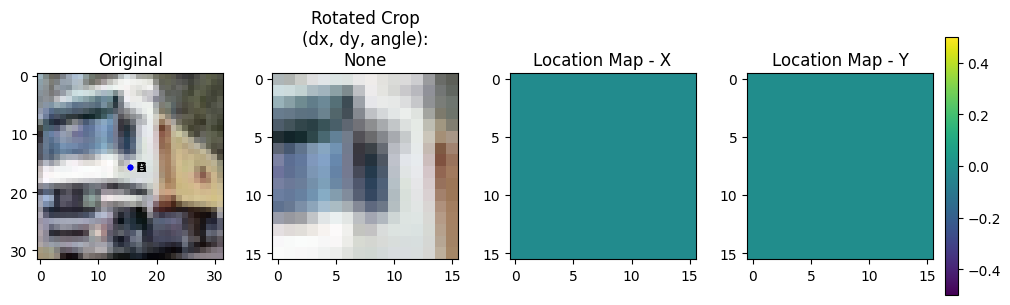

In [111]:
show_model_output(dataset, model)

**Instrumented training**

In [113]:
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - loss: 0.0370


Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.0366
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0359
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0367
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0364
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0368
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0365
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0361
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0367
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0369


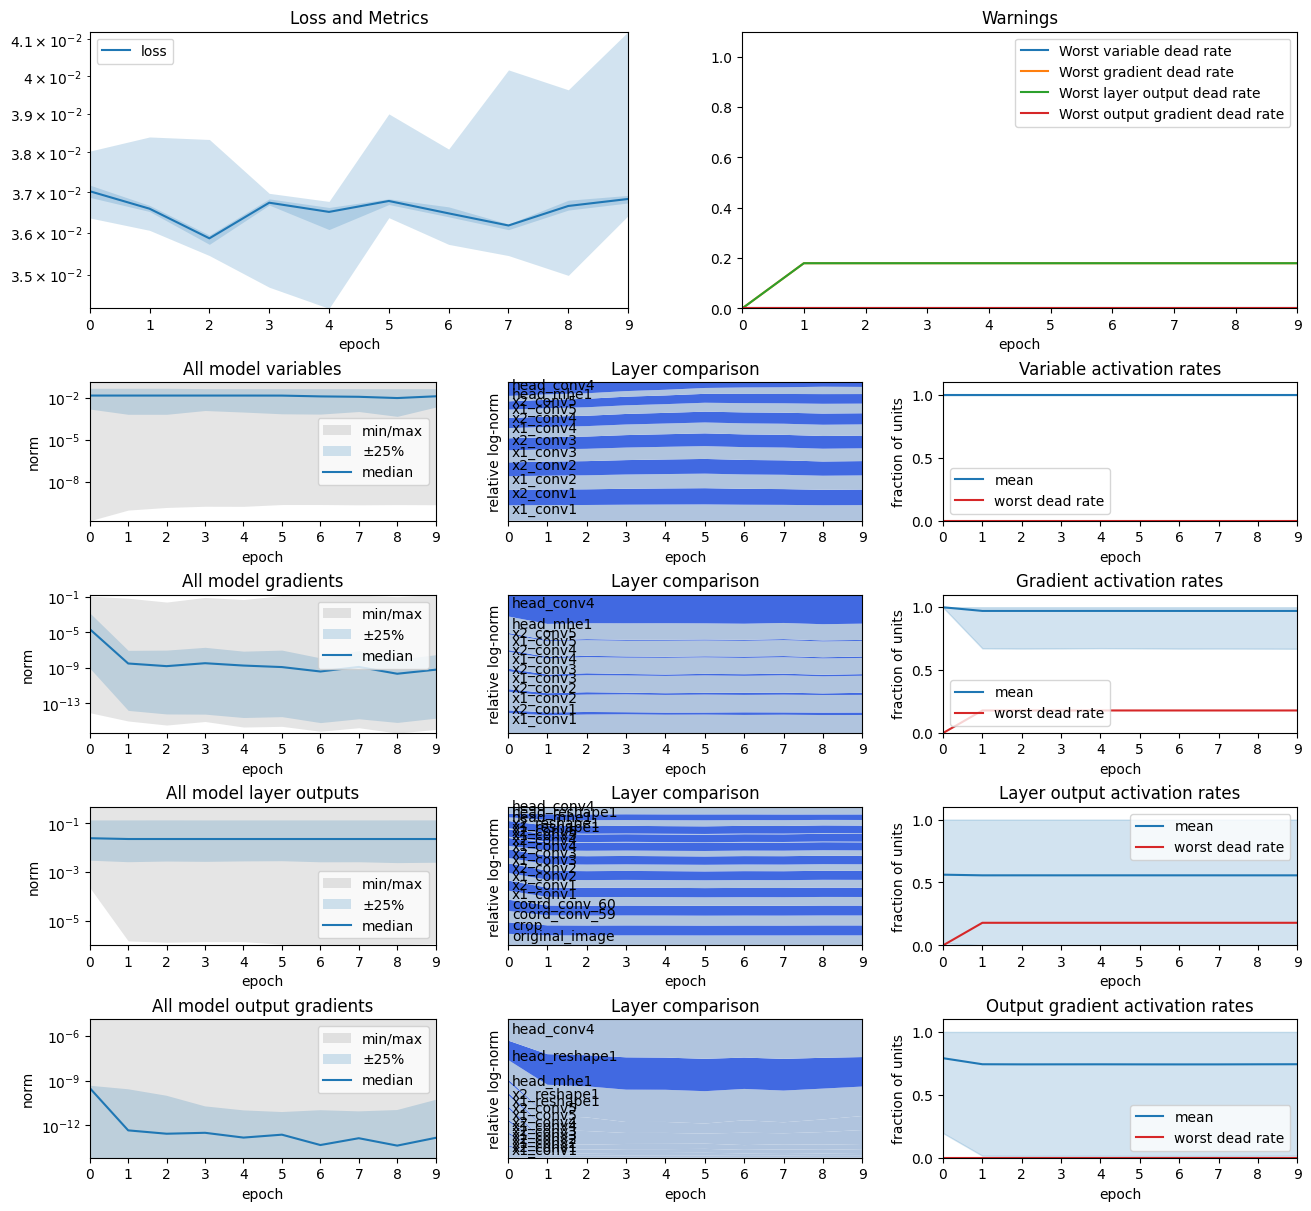

In [114]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

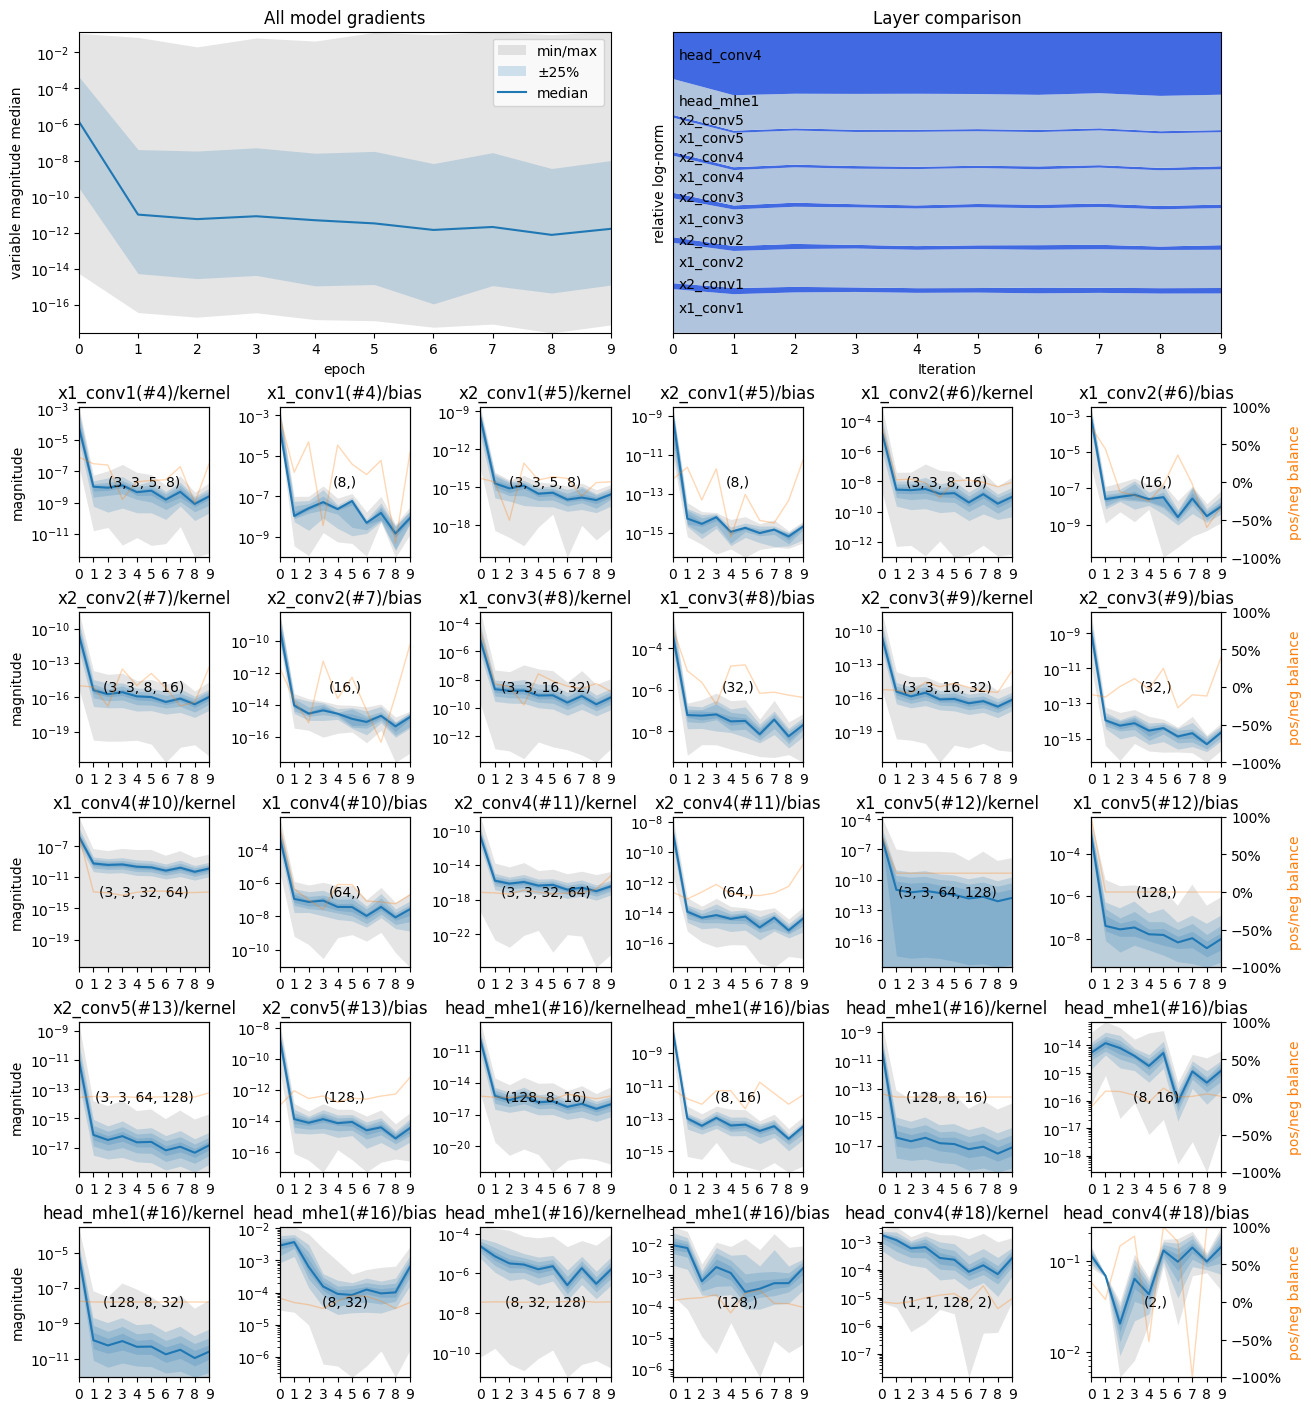

In [115]:
tinstr.plot_value_history(gradients)

In [118]:
[v.path for v in model.variables]

['x1_conv1/kernel',
 'x1_conv1/bias',
 'x2_conv1/kernel',
 'x2_conv1/bias',
 'x1_conv2/kernel',
 'x1_conv2/bias',
 'x2_conv2/kernel',
 'x2_conv2/bias',
 'x1_conv3/kernel',
 'x1_conv3/bias',
 'x2_conv3/kernel',
 'x2_conv3/bias',
 'x1_conv4/kernel',
 'x1_conv4/bias',
 'x2_conv4/kernel',
 'x2_conv4/bias',
 'x1_conv5/kernel',
 'x1_conv5/bias',
 'x2_conv5/kernel',
 'x2_conv5/bias',
 'head_mhe1/query/kernel',
 'head_mhe1/query/bias',
 'head_mhe1/key/kernel',
 'head_mhe1/key/bias',
 'head_mhe1/value/kernel',
 'head_mhe1/value/bias',
 'head_mhe1/attention_output/kernel',
 'head_mhe1/attention_output/bias',
 'head_conv4/kernel',
 'head_conv4/bias']

## Attention as Position
Note: in implementing this, I found that the `attn_scores` matrix returend by layers.MultiHeadAttention wasn't correct for this cross-attention task with differently lengthed sequences. I wasn't able to figure out what was going wrong.

So I ended up just re-implementing the MHA instead.

In [139]:
class CrossAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, value_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.value_dim = value_dim
        self.sqrt_key_dim = tf.math.sqrt(tf.cast(self.key_dim, tf.float32))

        # Define trainable weight matrices for Q, K, V
        self.W_q = layers.Dense(num_heads * key_dim, use_bias=False, name="W_q")
        self.W_k = layers.Dense(num_heads * key_dim, use_bias=False, name="W_k")
        self.W_v = layers.Dense(num_heads * value_dim, use_bias=False, name="W_v")
        self.W_out = layers.Dense(value_dim, use_bias=False, name="W_out")  # Final projection

    def call(self, query, key, value, return_attention_scores=False):
        """
        Args:
          query, key, value - Expecting (batch, seq_len, channels) for each,
            but seq_len for query/key can be different, and channels can
            be different.
        """

        batch_size = tf.shape(query)[0]
        q_len = tf.shape(query)[1]  # 256
        k_len = tf.shape(key)[1]    # 1024

        # Linear projections
        q = self.W_q(query)  # (batch, q_len, num_heads * key_dim)
        k = self.W_k(key)    # (batch, k_len, num_heads * key_dim)
        v = self.W_v(value)  # (batch, k_len, num_heads * value_dim)

        # Reshape for multi-heads: (batch, seq_len, num_heads, head_dim) -> (batch, num_heads, seq_len, head_dim)
        q = tf.reshape(q, [batch_size, q_len, self.num_heads, self.key_dim])
        k = tf.reshape(k, [batch_size, k_len, self.num_heads, self.key_dim])
        v = tf.reshape(v, [batch_size, k_len, self.num_heads, self.value_dim])

        q = tf.transpose(q, [0, 2, 1, 3])  # (batch, num_heads, q_len, key_dim)
        k = tf.transpose(k, [0, 2, 1, 3])  # (batch, num_heads, k_len, key_dim)
        v = tf.transpose(v, [0, 2, 1, 3])  # (batch, num_heads, k_len, value_dim)

        # Compute scaled dot-product attention: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
        attn_logits = tf.matmul(q, k, transpose_b=True)  # (batch, num_heads, q_len, k_len)
        attn_logits = attn_logits / self.sqrt_key_dim
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)  # Normalize across keys (k_len=1024)

        # Compute attention output
        attn_output = tf.matmul(attn_weights, v)  # (batch, num_heads, q_len, value_dim)

        # Transpose and reshape back to (batch, q_len, num_heads * value_dim)
        attn_output = tf.transpose(attn_output, [0, 2, 1, 3])  # (batch, q_len, num_heads, value_dim)
        attn_output = tf.reshape(attn_output, [batch_size, q_len, self.num_heads * self.value_dim])

        # Final projection back to value_dim
        attn_output = self.W_out(attn_output)  # (batch, q_len, value_dim)

        if return_attention_scores:
          return attn_output, attn_weights  # Also returning attention scores
        else:
          return attn_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "value_dim": self.value_dim
        })
        return config

class AttendedValues(layers.Layer):
  def __init__(self, head_reduction=None, **kwargs):
    super().__init__(**kwargs)
    self.head_reduction = head_reduction

  def call(self, attn_scores, values):
    """
    Args:
      - attn_scores: (batch, query_tokens, key_tokens)
      - values: (key_tokens, ..any..)
    Returns:
      - (batch, query_tokens, ..any..)
    """
    if self.head_reduction == 'mean':
        attn_scores = tf.reduce_mean(attn_scores, axis=1)  # (batch, heads, query_tokens, key_tokens) -> (batch, query_tokens, key_tokens)
    elif self.head_reduction is not None:
        raise ValueError(f"unknown head_reduction: {self.head_reduction}")
    return tf.linalg.matmul(attn_scores, values)

    def get_config(self):
        config = super().get_config()
        config.update({
            "head_reduction": self.head_reduction
        })
        return config

def attn_as_location_map_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    # - then average across attention heads: (batch, heads, 256, 1024) -> -> (batch, 256, 1024)
    # print(f"x1: {x1.shape}")
    # print(f"x2: {x2.shape}")
    mha = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mha")
    attn_output, attn_scores = mha(query=x2, key=x1, value=x1, return_attention_scores=True)  # (batch, 256, 32), (batch, 8, 256, 1024)
    # print(f"attn_output: {attn_output.shape}")
    # print(f"attn_scores: {attn_scores.shape}")

    # Generate normalized position meshgrid for x1 (32x32 grid in range -0.5..+0.5)
    # Compute weighted sum: Attention weights * Position grid
    grid_x, grid_y = tf.meshgrid(
        tf.linspace(-0.5, 0.5, 32),
        tf.linspace(-0.5, 0.5, 32),
        indexing="xy"
    )
    pos_grid = tf.stack([grid_x, grid_y], axis=-1)  # (32, 32, 2)
    pos_grid = tf.reshape(pos_grid, [1024, 2])  # Flatten to (1024, 2)
    position_map = AttendedValues(head_reduction='mean', name='head_av')(attn_scores, pos_grid)

    # Output
    x = layers.Reshape((16, 16, -1), name='head_reshape')(position_map)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
attn_as_location_map_model().summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2 (Conv2D)         │ (None, 32, 32, 16)     │          1,168 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2 (Conv2D)         │ (None, 16, 16, 16)     │          1,168 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ x1_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ x2_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ x1_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv4 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ x2_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv5 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ x1_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv5 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ x2_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 128)      │              0 │ x1_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 128)       │              0 │ x2_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mha (CrossAttention) │ [(None, 256, 32),      │         73,728 │ x1_reshape[0][0],      │
│                           │ (None, 8, 256, 1024)]  │                │ x2_reshape[0][0],      │
│                           │                        │                │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_av (AttendedValues)  │ (None, 256, 2)         │              0 │ head_mha[0][1]         │
├──────────────────────

 Total params: 270,784 (1.03 MB)

 Trainable params: 270,784 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
model = attn_as_location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['head_mha/W_v/kernel', 'head_mha/W_out/kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0324
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0259
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0251
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0253
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0249
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0256
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0249
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0251
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0248
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0250
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0248
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0240
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0235
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0228
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━

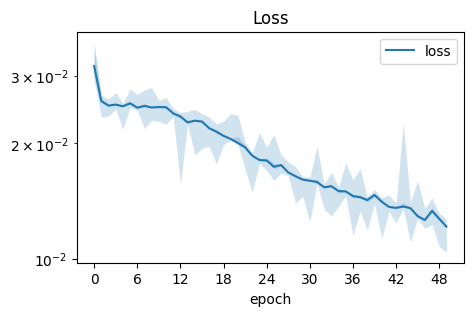

In [141]:
tinstr.plot_train_history(history)

Corners of crop image (raw):
    [-0.32962787 -0.05174556]                -         [ 0.13583273 -0.10718   ]
    [-0.27419344  0.413715  ]                -         [0.19126713 0.3582806 ]
Corners of crop image (pixels):
    [ 5.451908 14.344142]                -         [20.346647 12.57024 ]
    [ 7.22581 29.23888]                -         [22.120548 27.46498 ]


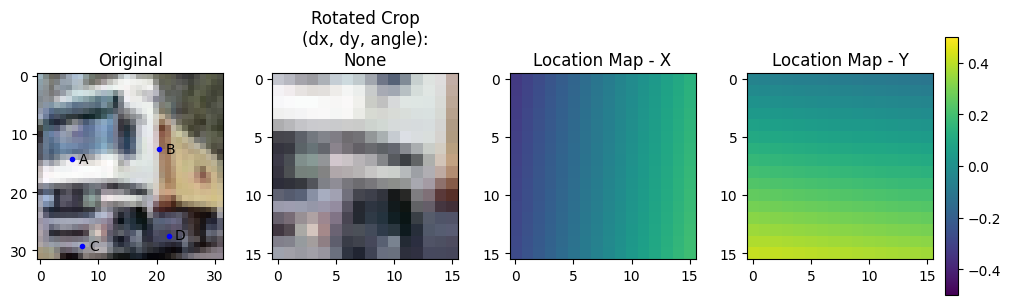

Corners of crop image (raw):
    [-0.20912074 -0.15157738]                -         [ 0.02183489 -0.13955243]
    [-0.2590036   0.17112957]                -         [0.18082458 0.2995731 ]
Corners of crop image (pixels):
    [ 9.308136 11.149524]                -         [16.698717 11.534323]
    [ 7.7118845 21.476147 ]                -         [21.786386 25.586338]


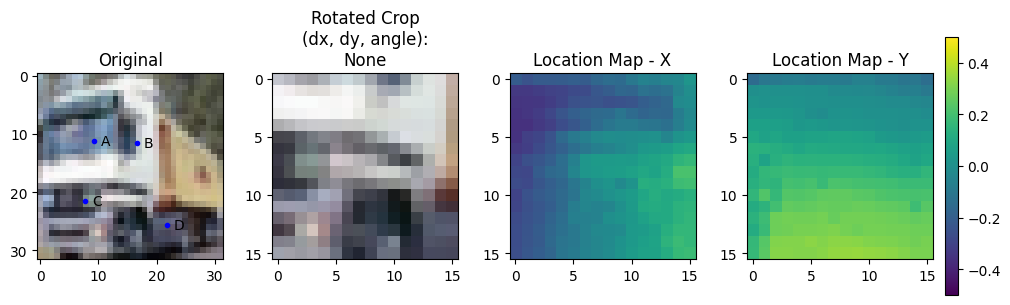

In [142]:
show_model_output(dataset, model)

**Equivalent but with more capacity**


In [144]:
def attn_as_location_map_model2():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1a')(x1)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1b')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2a')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2b')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3a')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3b')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4a')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4b')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5a')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5b')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1a')(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1b')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2a')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2b')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3a')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3b')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4a')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4b')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5a')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5b')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    # - then average across attention heads: (batch, heads, 256, 1024) -> -> (batch, 256, 1024)
    # print(f"x1: {x1.shape}")
    # print(f"x2: {x2.shape}")
    mha = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mha")
    attn_output, attn_scores = mha(query=x2, key=x1, value=x1, return_attention_scores=True)  # (batch, 256, 32), (batch, 8, 256, 1024)
    # print(f"attn_output: {attn_output.shape}")
    # print(f"attn_scores: {attn_scores.shape}")

    # Generate normalized position meshgrid for x1 (32x32 grid in range -0.5..+0.5)
    # Compute weighted sum: Attention weights * Position grid
    grid_x, grid_y = tf.meshgrid(
        tf.linspace(-0.5, 0.5, 32),
        tf.linspace(-0.5, 0.5, 32),
        indexing="xy"
    )
    pos_grid = tf.stack([grid_x, grid_y], axis=-1)  # (32, 32, 2)
    pos_grid = tf.reshape(pos_grid, (1024, 2))  # Flatten to (1024, 2)
    position_map = AttendedValues(head_reduction='mean', name='head_av')(attn_scores, pos_grid)

    # Output
    x = layers.Reshape((16, 16, -1), name='head_reshape')(position_map)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
attn_as_location_map_model2().summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1a (Conv2D)        │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1a (Conv2D)        │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1b (Conv2D)        │ (None, 32, 32, 8)      │            584 │ x1_conv1a[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1b (Conv2D)        │ (None, 16, 16, 8)      │            584 │ x2_conv1a[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2a (Conv2D)        │ (None, 32, 32, 16)     │          1,168 │ x1_conv1b[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2a (Conv2D)        │ (None, 16, 16, 16)     │          1,168 │ x2_conv1b[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2b (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ x1_conv2a[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2b (Conv2D)        │ (None, 16, 16, 16)     │          2,320 │ x2_conv2a[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3a (Conv2D)        │ (None, 32, 32, 32)     │          4,640 │ x1_conv2b[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3a (Conv2D)        │ (None, 16, 16, 32)     │          4,640 │ x2_conv2b[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3b (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ x1_conv3a[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3b (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ x2_conv3a[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4a (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ x1_conv3b[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv4a (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ x2_conv3b[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4b (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ x1_conv4a[0][0]        │
├──────────────────────

 Total params: 664,112 (2.53 MB)

 Trainable params: 664,112 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
model = attn_as_location_map_model2()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['head_mha/W_v/kernel', 'head_mha/W_out/kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - loss: 0.0363
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0340
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0296
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0256
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0252
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0253
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0249
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0257
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0250
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0241
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0243
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0243
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0249
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0246
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━

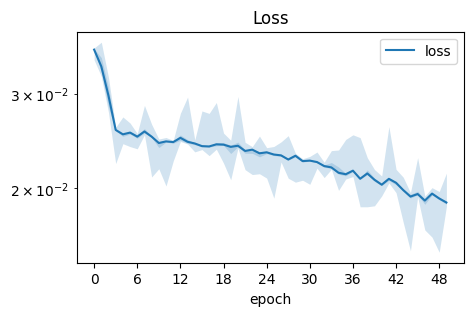

In [146]:
tinstr.plot_train_history(history)

Corners of crop image (raw):
    [-0.38157132 -0.42021996]                -         [ 0.07774419 -0.51379275]
    [-0.2879985   0.03909552]                -         [ 0.17131698 -0.05447727]
Corners of crop image (pixels):
    [3.7897177 2.5529613]                -         [18.487814  -0.4413681]
    [ 6.784048 17.251057]                -         [21.482143 14.256727]


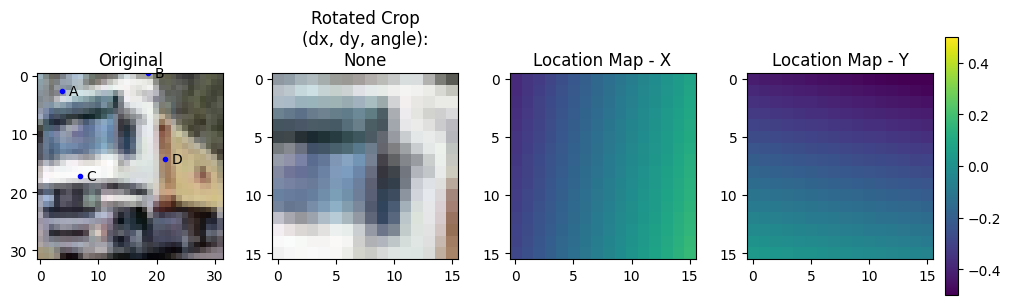

Corners of crop image (raw):
    [-0.20023929 -0.11415354]                -         [ 0.12965754 -0.25773638]
    [-0.18761009  0.00281266]                -         [0.15981862 0.00312855]
Corners of crop image (pixels):
    [ 9.592342 12.347087]                -         [20.14904    7.7524357]
    [ 9.996477 16.090006]                -         [21.114197 16.100113]


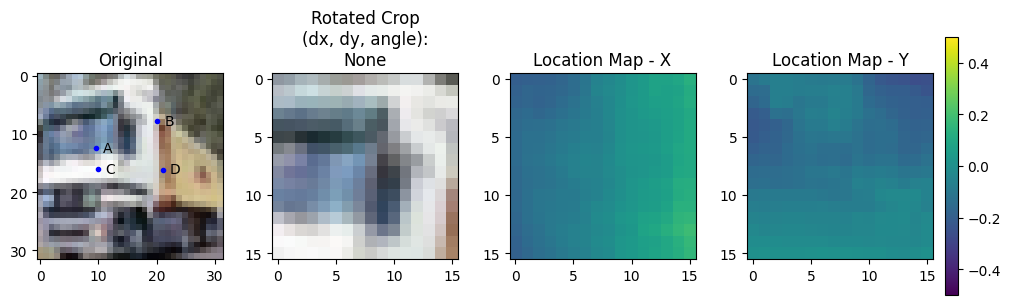

In [147]:
show_model_output(dataset, model)

## Dumb model

In [101]:
def dumb_location_map_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> 16x16x128
    x1 = CoordConv()(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.MaxPool2D(pool_size=(2, 2), padding='same', name='x1_maxpool1')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128
    x2 = CoordConv()(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)

    # Cross-attention to spatial
    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(filters=32, kernel_size=1, name='head_conv1')(x)
    x = layers.Conv2D(filters=32, kernel_size=1, name='head_conv2')(x)
    x = layers.Conv2D(filters=32, kernel_size=1, name='head_conv3')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='head_conv4')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
dumb_location_map_model().summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coord_conv_45 (CoordConv) │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ coord_conv_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coord_conv_46 (CoordConv) │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2 (Conv2D)         │ (None, 32, 32, 16)     │          1,168 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ coord_conv_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ x1_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2 (Conv2D)         │ (None, 16, 16, 16)     │          1,168 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ x1_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ x2_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv5 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ x1_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv4 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ x2_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_maxpool1               │ (None, 16, 16, 128)    │              0 │ x1_conv5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv5 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ x2_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 16, 16, 256)    │              0 │ x1_maxpool1[0][0],     │
│ (Concatenate)             │                        │                │ x2_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_conv1 (Conv2D)       │ (None, 16, 16, 32)     │          8,224 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_conv2 (Conv2D)       │ (None, 16, 16, 32)     │          1,056 │ head_conv1[0][0]       │
├──────────────────────

 Total params: 207,458 (810.38 KB)

 Trainable params: 207,458 (810.38 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
model = dumb_location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0302
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0261
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0255
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0253
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0248
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0250
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0251
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0248
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0246
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0243
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0245
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0240
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0249
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0247
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s

Corners of crop image (raw):
    [-0.31135714 -0.32916632]                -         [ 0.15717828 -0.34334868]
    [-0.29717478  0.13936907]                -         [0.17136061 0.12518674]
Corners of crop image (pixels):
    [6.0365715 5.4666777]                -         [21.029705  5.012842]
    [ 6.490407 20.45981 ]                -         [21.48354  20.005976]


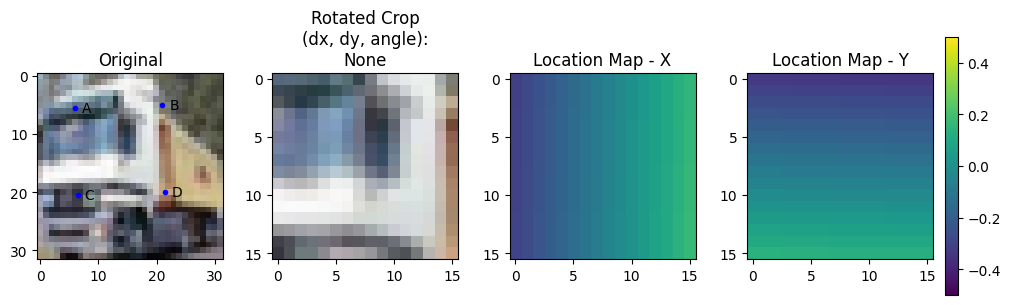

Corners of crop image (raw):
    [-0.1487754  -0.20743258]                -         [ 0.14197518 -0.17470388]
    [-0.1865606   0.11772848]                -         [0.1192439  0.11386461]
Corners of crop image (pixels):
    [11.239187  9.362158]                -         [20.543205 10.409475]
    [10.030061 19.767311]                -         [19.815805 19.643667]


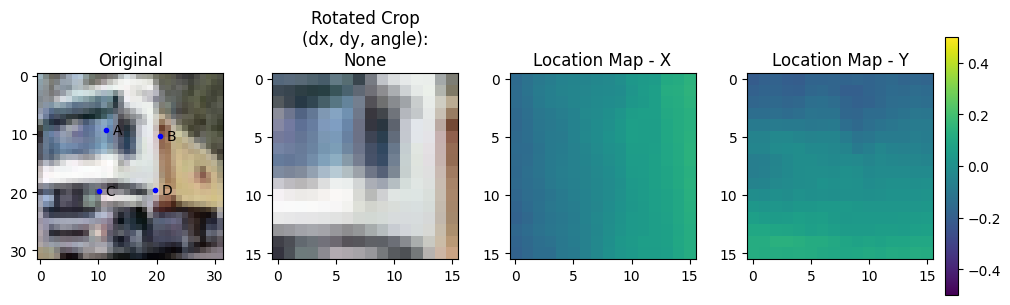

In [106]:
show_model_output(dataset, model)

## Instrumented training

In [108]:
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = dumb_location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0279


Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0262
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0251
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0250
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0254
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0252
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0248
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0244
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0245
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0248


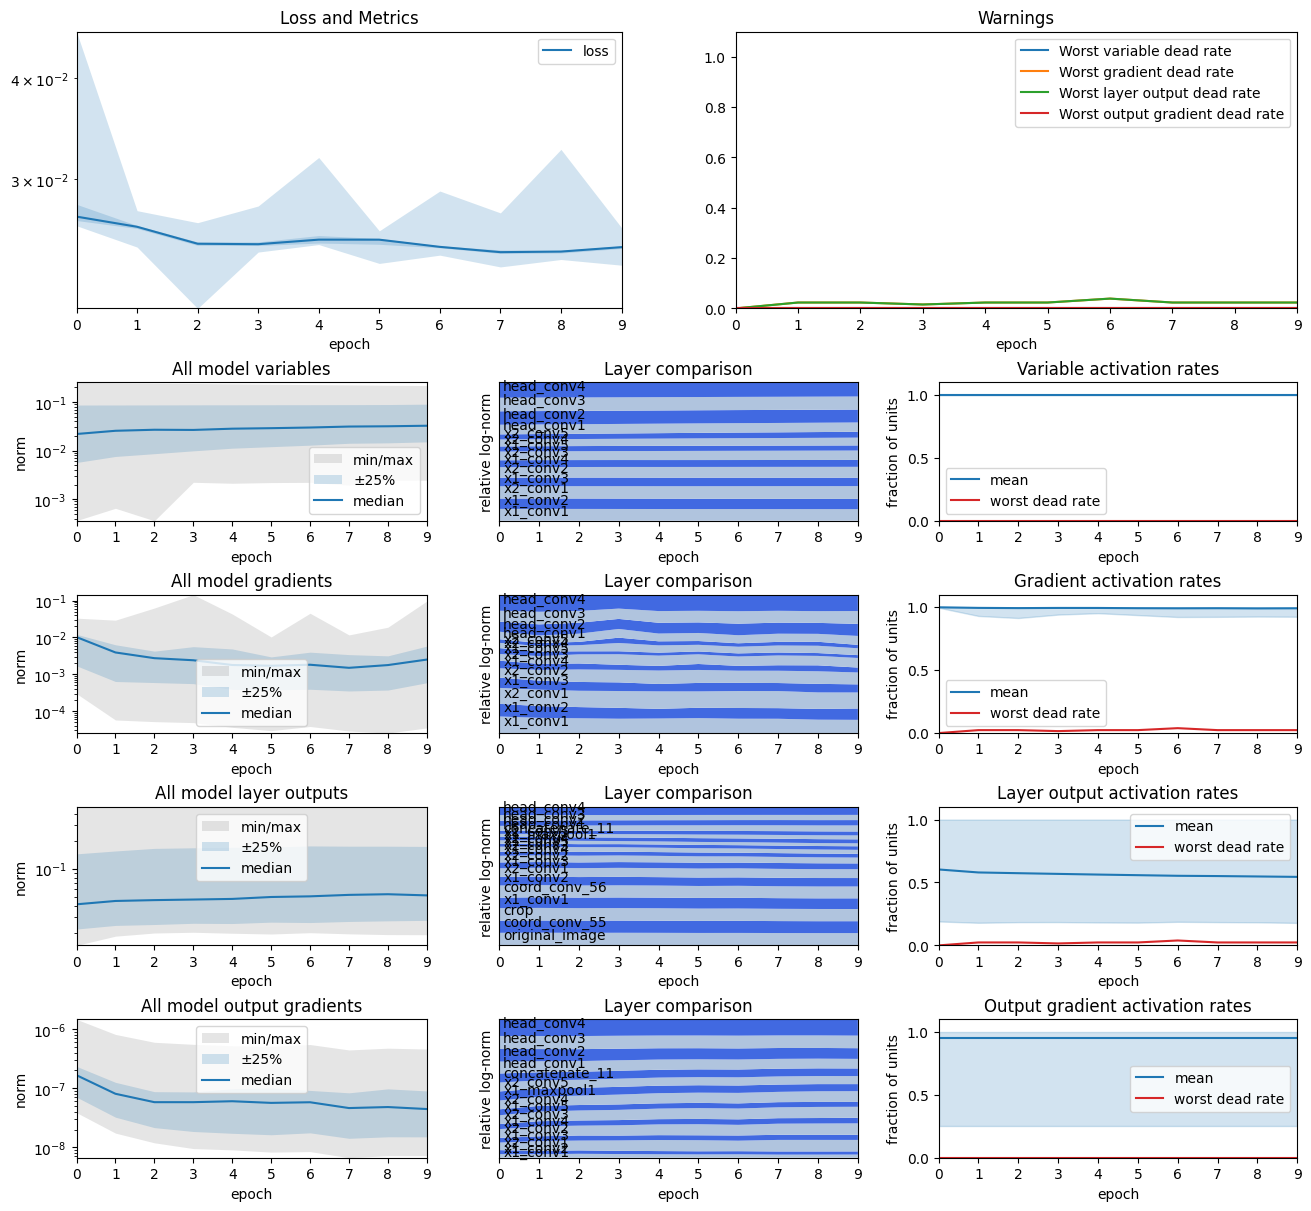

In [109]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])